# Quick Initial Analysis

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import math

df = pd.read_excel("data/morphology_data.xlsx", sheet_name="morphology_EQ_Geneva")
df.head()

,id,left,top,right,bottom,row_index,col_index,field_1,PC1,PC2,...,noiseday_m,noisenight,bin_lst_me,bin_solar_,bin_sola_1,bin_pm10_m,bin_pm25_m,bin_no2_me,bin_noised,bin_noisen
0,36,2497723.99,1118389.101,2497973.99,1118139.101,10,1,1343,0.526055,0.338480,...,-1.409763,-1.450883,"(-0.699,-0.0567]","(0.658,2.84]","(0.529,3.4]","(-2.17,-0.717]","(-1.73,-0.731]","(-2.33,-0.72]","(-2.7,-0.657]","(-2.55,-0.65]"
1,37,2497723.99,1118139.101,2497973.99,1117889.101,11,1,1344,0.851423,0.674067,...,-0.495672,-0.757194,"(-2.4,-0.699]","(0.658,2.84]","(0.529,3.4]","(-2.17,-0.717]","(-1.73,-0.731]","(-2.33,-0.72]","(-0.657,0.0621]","(-2.55,-0.65]"
2,38,2497723.99,1117889.101,2497973.99,1117639.101,12,1,1345,-0.752449,0.148228,...,0.247978,0.128687,"(-0.699,-0.0567]","(-0.0457,0.658]","(-0.31,0.529]","(-0.717,-0.162]","(-0.731,-0.152]","(-0.72,-0.0796]","(0.0621,0.737]","(0.106,0.611]"
3,39,2497723.99,1117639.101,2497973.99,1117389.101,13,1,1346,1.066390,-0.858294,...,-0.072170,-0.152906,"(-2.4,-0.699]","(-2.51,-0.611]","(-1.71,-0.722]","(-2.17,-0.717]","(-0.731,-0.152]","(-2.33,-0.72]","(-0.657,0.0621]","(-0.65,0.106]"
4,40,2497723.99,1117389.101,2497973.99,1117139.101,14,1,1347,-0.433673,-0.642512,...,0.762563,0.617922,"(0.716,2.72]","(0.658,2.84]","(0.529,3.4]","(-0.717,-0.162]","(-0.731,-0.152]","(-2.33,-0.72]","(0.737,2.34]","(0.611,2.66]"


In [2]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of rows: 241
Number of features: 34


In [3]:
df["typology"].value_counts()

typology
A    58
E    42
J    27
B    26
C    25
G    25
D    20
I    12
F     5
K     1
Name: count, dtype: int64

In [4]:
print(df.columns.unique())

Index(['id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index',
       'field_1', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'typology', 'city',
       'z_distance', 'q_cluster', 'lst_mean', 'solar_summ', 'solar_wint',
       'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight',
       'bin_lst_me', 'bin_solar_', 'bin_sola_1', 'bin_pm10_m', 'bin_pm25_m',
       'bin_no2_me', 'bin_noised', 'bin_noisen'],
      dtype='object')


In [5]:
# Print the columns with unique values == len(df)

cols_to_remove = []
for col in df.columns:
    if col == "id":
        continue
    if df[col].nunique() == len(df) or df[col].nunique() <= 1:
        cols_to_remove.append(col)

print("Columns to remove: ", cols_to_remove)
df = df.drop(columns=cols_to_remove)

Columns to remove:  ['field_1', 'city']


In [6]:
features_to_remove = [
    "left",
    "top",
    "right",
    "bottom",
    "row_index",
    "col_index",
    "q_cluster",
    "z_distance",
]
df = df.drop(columns=features_to_remove)
print(f"Numbers of columns after removing metadata features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing metadata features: 24
Index(['id', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight', 'bin_lst_me', 'bin_solar_', 'bin_sola_1',
       'bin_pm10_m', 'bin_pm25_m', 'bin_no2_me', 'bin_noised', 'bin_noisen'],
      dtype='object')


In [7]:
# Remove the columns with the "bin" prefix, as they are binned versions of other columns
bin_columns = [col for col in df.columns if col.startswith("bin")]
df = df.drop(columns=bin_columns)
print(f"Numbers of columns after removing binned features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing binned features: 16
Index(['id', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight'],
      dtype='object')


In [8]:
# Print the rows where there are NaN values
original_rows_num = df.shape[0]
nan_rows = df[df.isna().any(axis=1)]
nan_rows
df.dropna(inplace=True)
print(f"Number of rows after dropping NaN values: {len(df)}")
print(f"Number of rows dropped: {original_rows_num - len(df)}")

Number of rows after dropping NaN values: 240
Number of rows dropped: 1


In [9]:
# Remove numeric columns with zero variance (constant columns)
numeric_cols = df.select_dtypes(include=["number"]).columns
zero_var_cols = [c for c in numeric_cols if abs(df[c].std()) <= 1e-8]
if zero_var_cols:
    print("Zero-variance numeric columns to remove:", zero_var_cols)
    df = df.drop(columns=zero_var_cols)
else:
    print("No zero-variance numeric columns found")
print(f"Columns remaining after removing zero-variance: {len(df.columns)}")

No zero-variance numeric columns found
Columns remaining after removing zero-variance: 16


In [10]:
# convert typology to categorical dtype
df["typology"] = df["typology"].astype("category")

In [11]:
# Save the cleaned dataframe
df.to_csv("data/morphology_data_cleaned.csv", index=False)

Compact **Exploratory Data Analysis (EDA)** of the cleaned morphological dataset regarding Geneva neighborhoods. Here we perform sanity checks, look at distributions, correlations,  structure of higher dimensional data PCA-derived, clustering tendencies as well as relationships between environmental quality and morphology-associated markers.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 240
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          240 non-null    int64   
 1   PC1         240 non-null    float64 
 2   PC2         240 non-null    float64 
 3   PC3         240 non-null    float64 
 4   PC4         240 non-null    float64 
 5   PC5         240 non-null    float64 
 6   PC6         240 non-null    float64 
 7   typology    240 non-null    category
 8   lst_mean    240 non-null    float64 
 9   solar_summ  240 non-null    float64 
 10  solar_wint  240 non-null    float64 
 11  pm10_mean   240 non-null    float64 
 12  pm25_mean   240 non-null    float64 
 13  no2_mean    240 non-null    float64 
 14  noiseday_m  240 non-null    float64 
 15  noisenight  240 non-null    float64 
dtypes: category(1), float64(14), int64(1)
memory usage: 30.6 KB


The features are already standardized, and they are also all continuous except for the id which is an integer and the typology which is a category

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,240.0,256.554167,110.487722,36.000000,166.750000,260.500000,344.250000,466.000000
PC1,240.0,-0.276652,0.990332,-4.838262,-0.906122,-0.138568,0.436716,1.921704
PC2,240.0,-0.007602,1.020836,-3.208794,-0.583750,0.038594,0.627072,4.381786
PC3,240.0,-0.133991,1.004006,-3.253529,-0.784161,-0.037030,0.458507,3.160354
PC4,240.0,-0.216103,0.944383,-3.014233,-0.888022,-0.258895,0.350770,2.422418
PC5,240.0,0.234959,0.814041,-2.517597,-0.379032,0.204648,0.693712,3.355186
PC6,240.0,0.268141,1.041847,-2.546661,-0.329660,0.208061,0.949746,4.888767
lst_mean,240.0,0.066048,1.013751,-2.398759,-0.698862,-0.043775,0.783261,2.719456
solar_summ,240.0,0.029420,1.028082,-3.959839,-0.407195,-0.205333,0.553019,5.038286
solar_wint,240.0,0.040750,0.994545,-2.147976,-0.514735,-0.192346,0.440508,4.570293


<Figure size 1200x800 with 0 Axes>

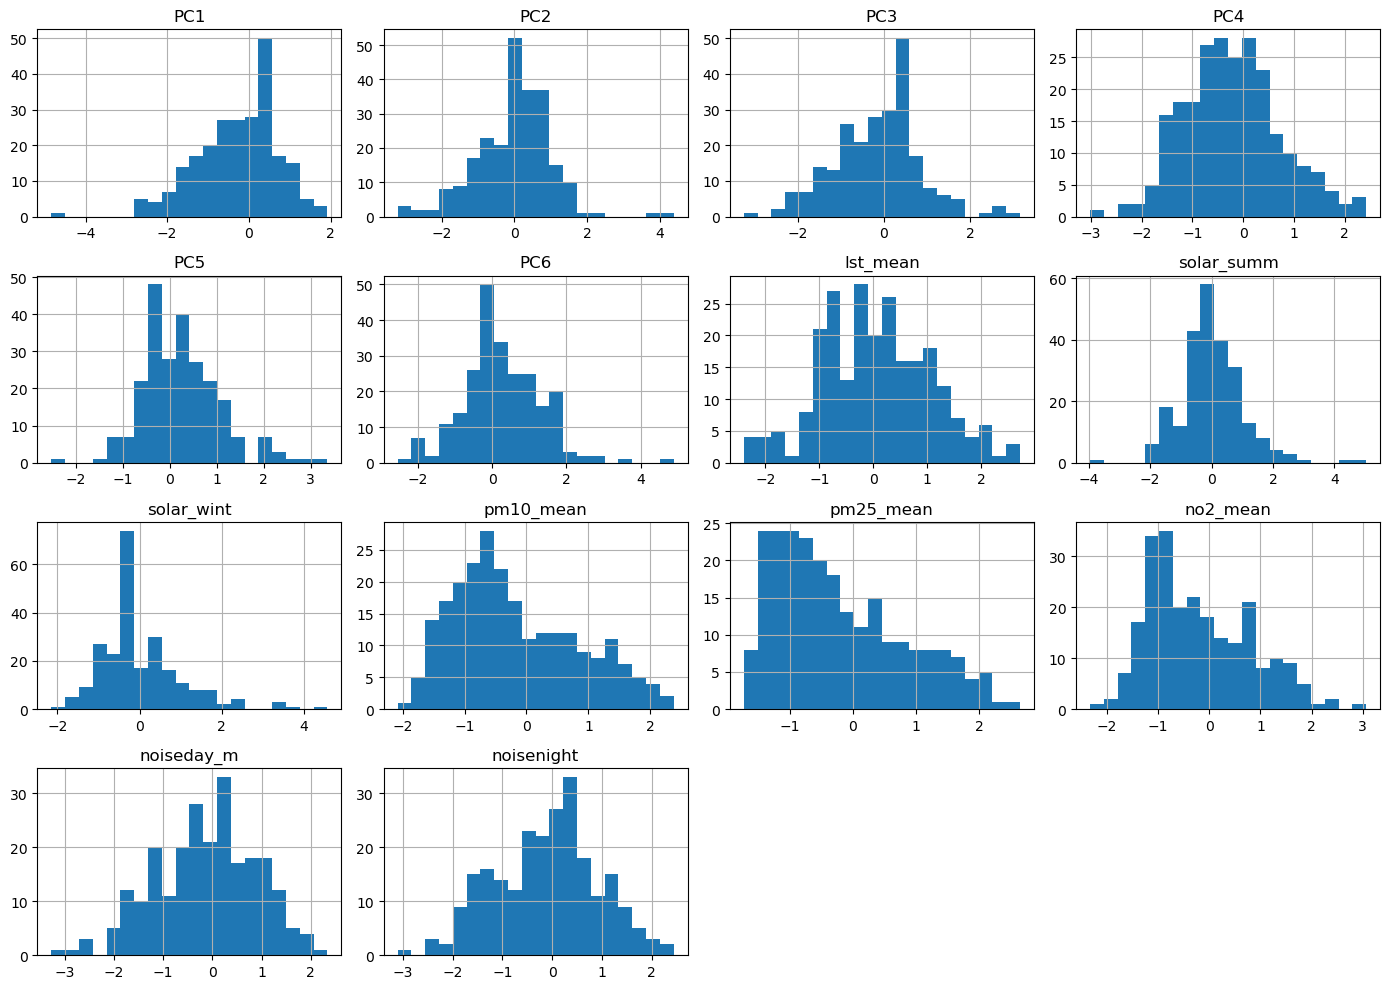

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# compact overview using histograms and Kernel Density Estimations (KDE)


morph_cols = [c for c in df.columns if c.startswith("PC")]
env_cols = [
    "lst_mean",
    "solar_summ",
    "solar_wint",
    "pm10_mean",
    "pm25_mean",
    "no2_mean",
    "noiseday_m",
    "noisenight",
]

plt.figure(figsize=(12, 8))
df[morph_cols + env_cols].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

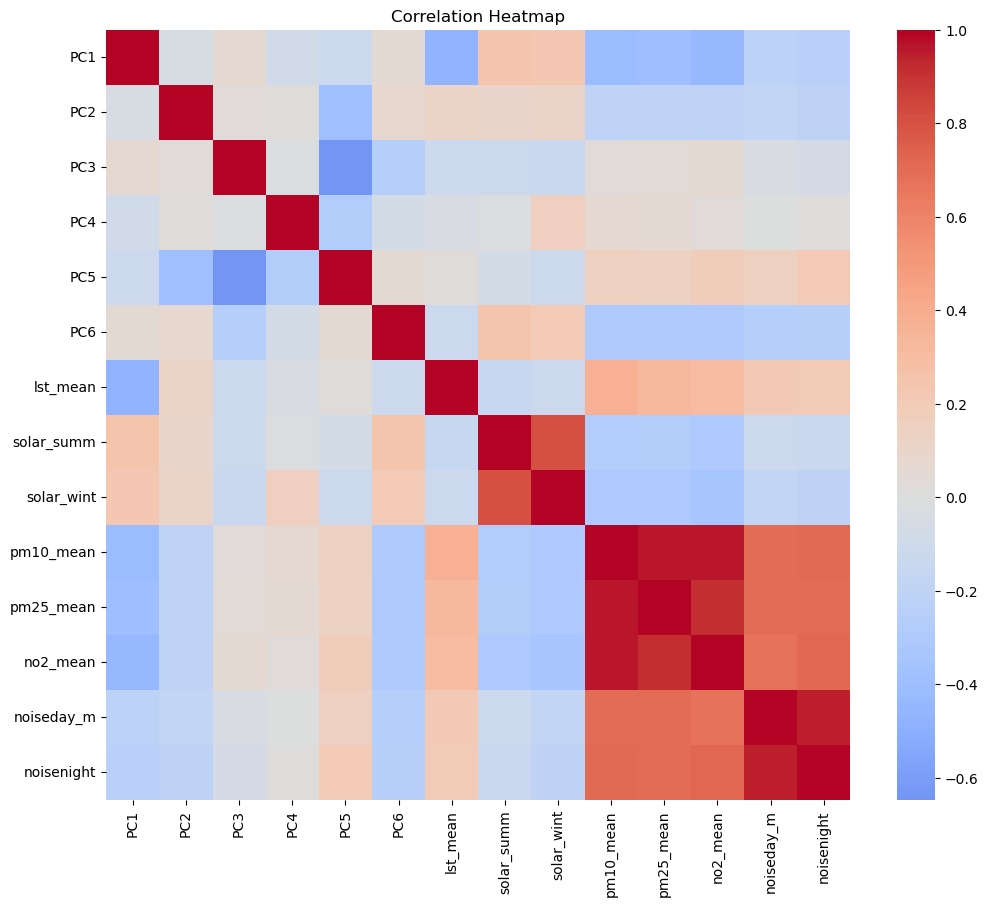

In [15]:
# correlation matrix, correlation between PCs serves as check for
# proper PCA execution and meaningfulness


plt.figure(figsize=(12, 10))
sns.heatmap(df[morph_cols + env_cols].corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

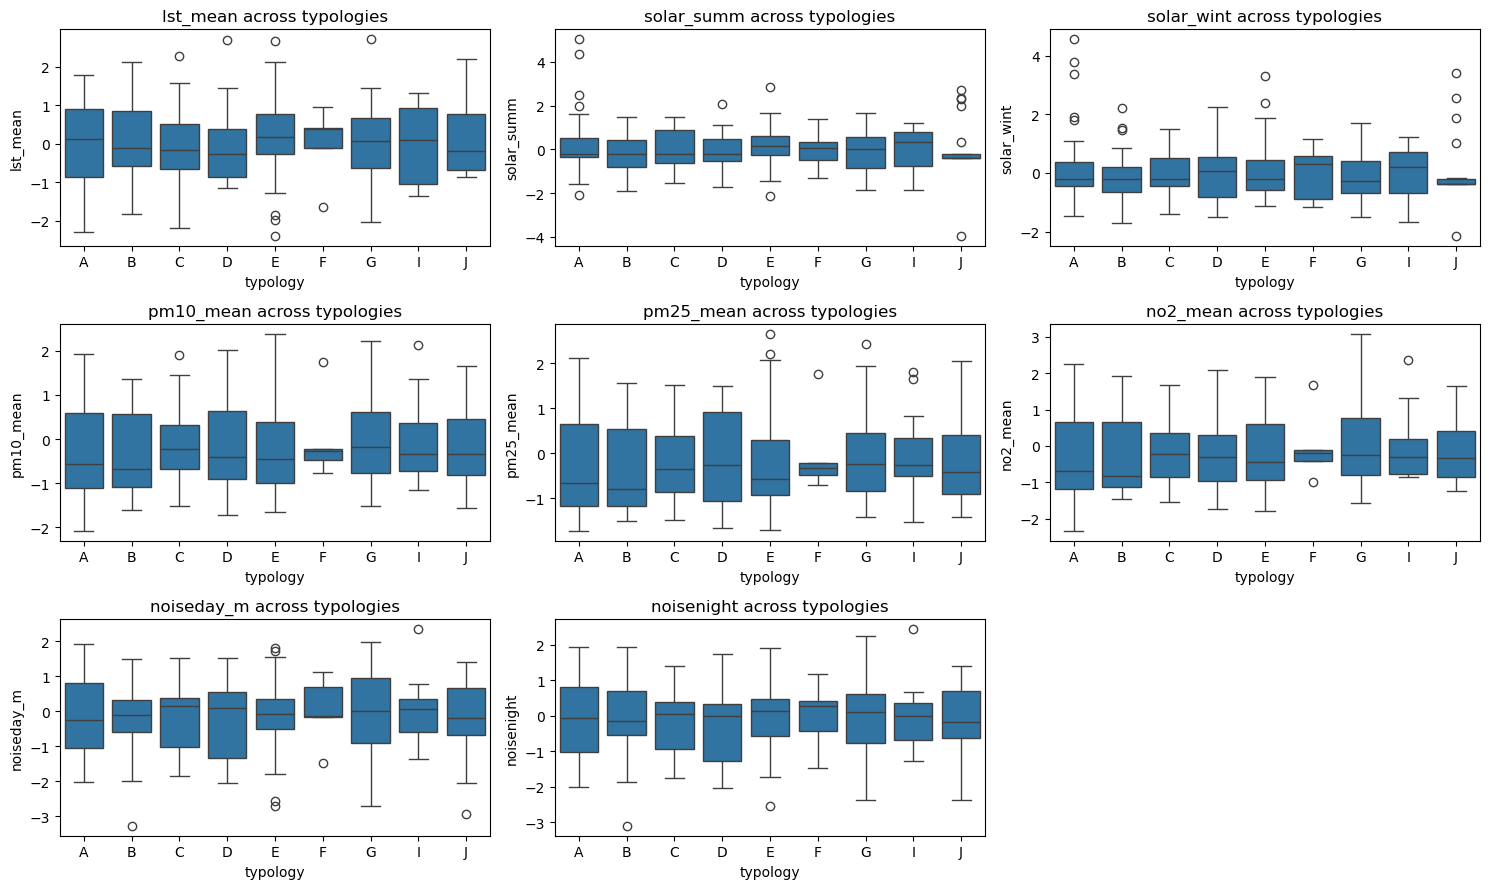

In [16]:
# Typology effects (categories derived from morphological PC-based clustering,
# raw data we have no access to). Do different typologies have different exposure?

# arrange the env feature boxplots into a single grid of subplots
n = len(env_cols)
cols = min(3, n)
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), squeeze=False)
axes_flat = axes.flatten()

for ax, var in zip(axes_flat, env_cols):
    sns.boxplot(data=df, x="typology", y=var, ax=ax)
    ax.set_title(f"{var} across typologies")
    plt.xticks(rotation=45)

# remove any unused axes (if n < rows*cols)
for ax in axes_flat[len(env_cols) :]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [17]:
# PCA structure check - correlations should be close to zero
df[morph_cols].corr()

,PC1,PC2,PC3,PC4,PC5,PC6
PC1,1.000000,-0.048286,0.066929,-0.090662,-0.129159,0.052013
PC2,-0.048286,1.000000,0.026513,0.016082,-0.394689,0.076820
PC3,0.066929,0.026513,1.000000,-0.019652,-0.646967,-0.256911
PC4,-0.090662,0.016082,-0.019652,1.000000,-0.274261,-0.070849
PC5,-0.129159,-0.394689,-0.646967,-0.274261,1.000000,0.049985
PC6,0.052013,0.076820,-0.256911,-0.070849,0.049985,1.000000


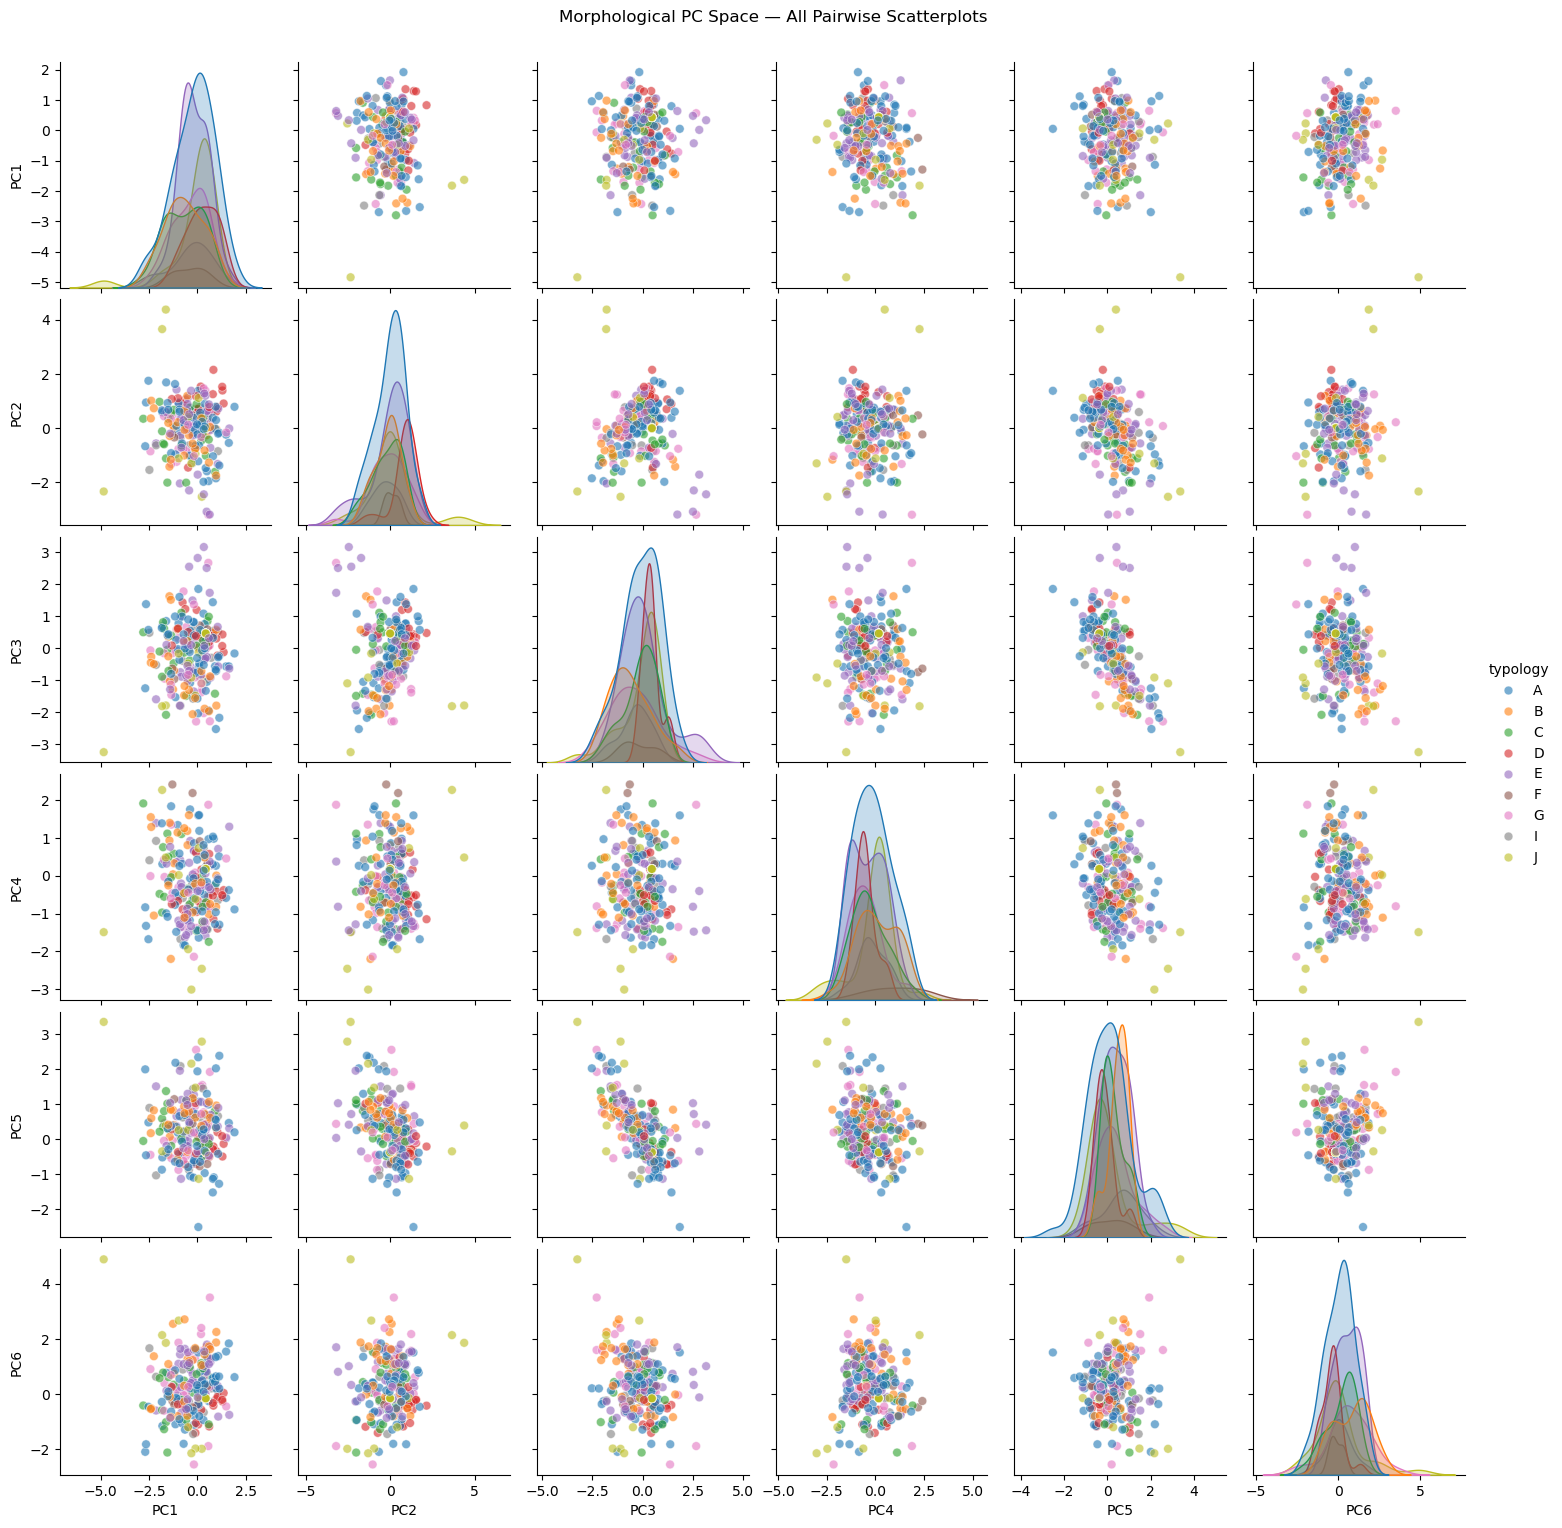

In [18]:
# all PC pairs in a grid
sns.pairplot(df, vars=morph_cols, hue="typology", plot_kws={"alpha": 0.6, "s": 40})
plt.suptitle("Morphological PC Space — All Pairwise Scatterplots", y=1.02)
plt.show()

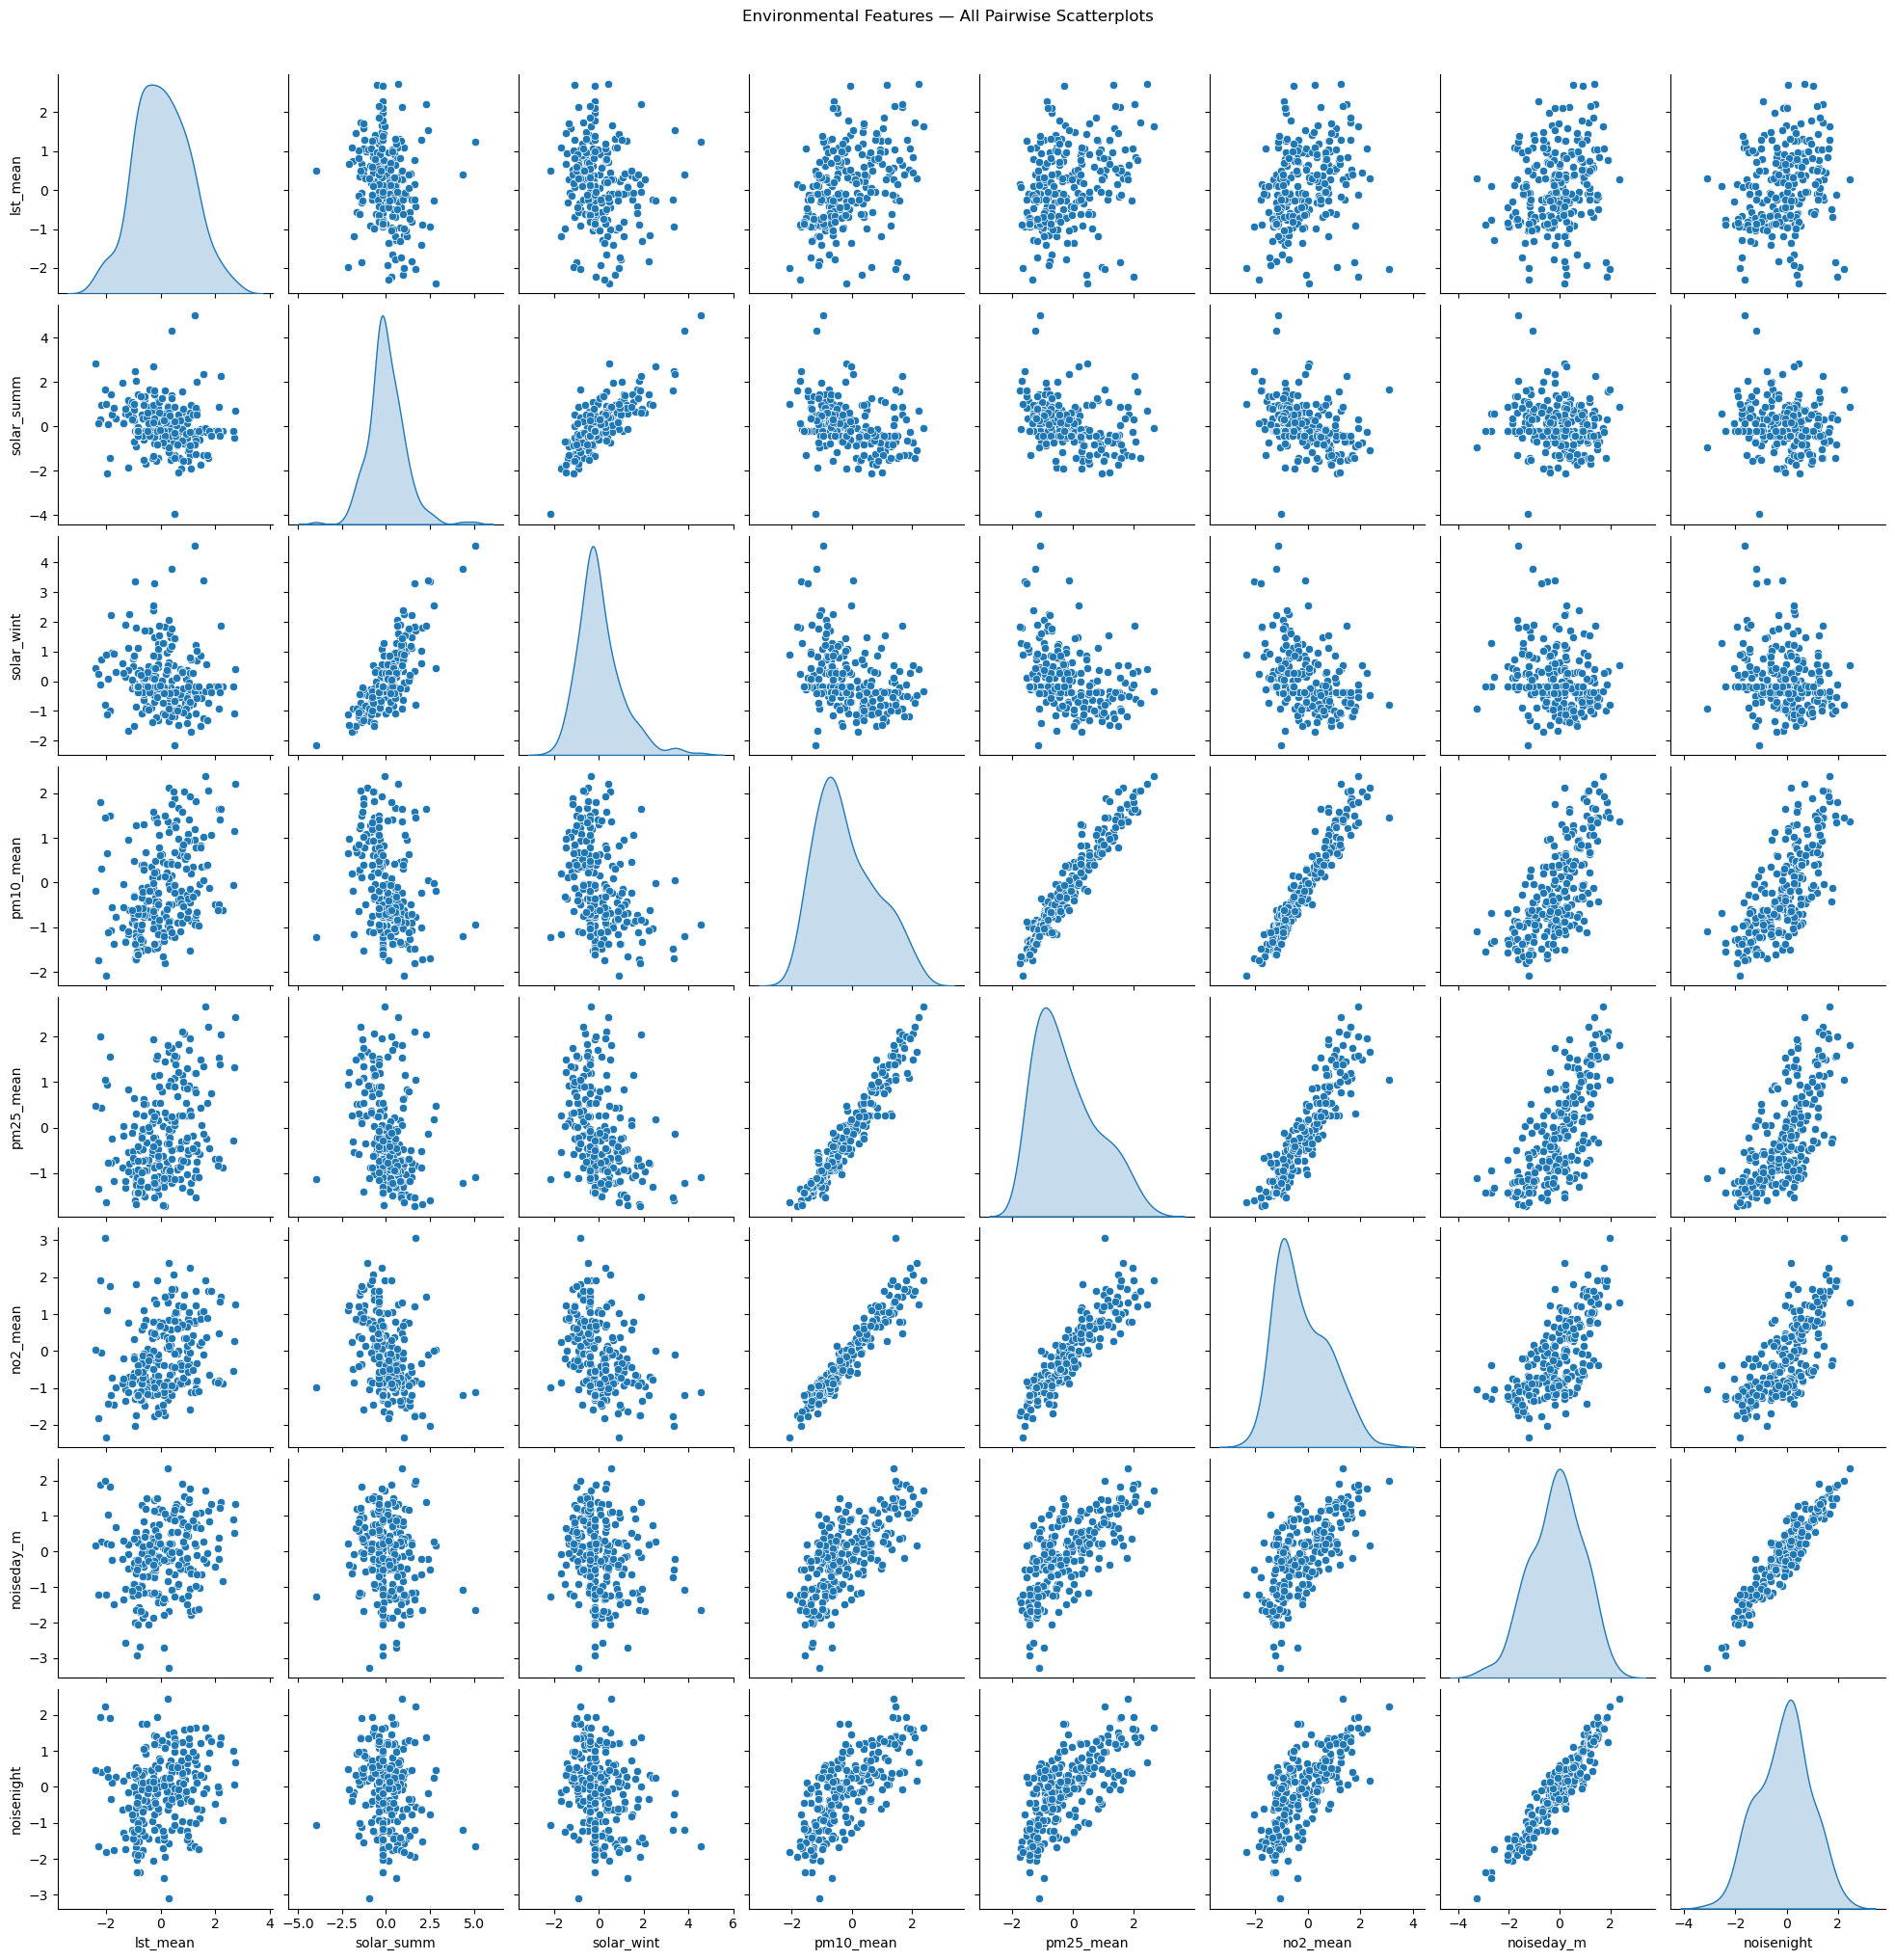

In [19]:
# pairplot for compact visual overview to show all pairwise scatter plots, maybe catch nonlinear relations
sns.pairplot(df[env_cols], diag_kind="kde")
plt.suptitle("Environmental Features — All Pairwise Scatterplots", y=1.02)
plt.show()

# Pipeline

In [20]:
from src.utils.pipeline import (
    assign_age_quantile_bins,
    build_feature_matrix,
    load_combined_dataset,
)
from src.feature_config import (
    ALL_CONTINUOUS_FEATURES,
    POSSIBLE_TARGET_FEATURES,
    determine_target_type,
)
from src.feature_selection import compute_associations
from src.predictive import run_modeling_suite

In [21]:
df = load_combined_dataset(
    "data/morphology_data_cleaned.csv",
    "data/synthetic_health_data.xlsx",
)
df = assign_age_quantile_bins(df)

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (2631, 34)


In [22]:
features = build_feature_matrix(
    df,
    excluded_targets=POSSIBLE_TARGET_FEATURES,
)

In [23]:
features.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'lst_mean', 'solar_summ',
       'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m',
       'noisenight', 'typology_A', 'typology_B', 'typology_C', 'typology_D',
       'typology_E', 'typology_F', 'typology_G', 'typology_I', 'typology_J',
       'sex_Female', 'sex_Male', 'income_High', 'income_Low', 'income_Medium',
       'education_level_Bachelor', 'education_level_High School',
       'education_level_Master', 'education_level_PhD', 'age_bin_<= 33',
       'age_bin_33-49', 'age_bin_49-63', 'age_bin_> 63'],
      dtype='object')

In [24]:
features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,lst_mean,solar_summ,solar_wint,pm10_mean,...,income_Low,income_Medium,education_level_Bachelor,education_level_High School,education_level_Master,education_level_PhD,age_bin_<= 33,age_bin_33-49,age_bin_49-63,age_bin_> 63
0,0.526055,0.33848,0.846051,-1.420268,-0.217506,0.687111,-0.111053,1.130211,0.982144,-1.361464,...,True,False,True,False,False,False,False,True,False,False
1,0.526055,0.33848,0.846051,-1.420268,-0.217506,0.687111,-0.111053,1.130211,0.982144,-1.361464,...,False,False,False,False,False,True,False,False,False,True
2,0.526055,0.33848,0.846051,-1.420268,-0.217506,0.687111,-0.111053,1.130211,0.982144,-1.361464,...,False,True,False,False,False,True,False,False,True,False
3,0.526055,0.33848,0.846051,-1.420268,-0.217506,0.687111,-0.111053,1.130211,0.982144,-1.361464,...,False,False,False,False,False,True,False,False,True,False
4,0.526055,0.33848,0.846051,-1.420268,-0.217506,0.687111,-0.111053,1.130211,0.982144,-1.361464,...,True,False,False,True,False,False,False,False,False,True


We only have 14 continuous features so probably applying PCA doesn't make sense (also 6 of those 14 features are principal components of other data) 

In [25]:
print(
    f"Number of features that are continuous: {len([col for col in features.columns if col in ALL_CONTINUOUS_FEATURES])}",
)

Number of features that are continuous: 14


In [26]:
target_feature = "GHQ12_score"
target = df[target_feature]

target_feature_type = determine_target_type(target_feature)
if target_feature_type == "continuous":
    target = (target - target.mean()) / target.std()
    model_type = "regression"
elif target_feature_type == "categorical":
    model_type = "multi-class classification"
elif target_feature_type == "binary":
    model_type = "binary classification"
else:
    raise ValueError(f"Unsupported target type: {target_feature_type}")

In [27]:
association_df, vif_df = compute_associations(df, target_feature)

if not association_df.empty:
    display(association_df.reset_index(drop=True))
else:
    print("No association tests were computed for the current target configuration.")

if not vif_df.empty:
    display(vif_df.reset_index(drop=True))
else:
    print("Insufficient data to compute VIF values for the current feature set.")

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology,categorical,Univariate linear regression,coef[typology_C],0.590933,0.028766
1,d_breath_respiratory,binary,Univariate linear regression,coef[d_breath_respiratory],-0.358423,0.079449
2,d_breath_respiratory,binary,Point-biserial correlation,r_pb,-0.034200,0.079449
3,solar_summ,continuous,Univariate linear regression,coef[solar_summ],-0.088936,0.213544
4,solar_summ,continuous,Pearson correlation,r,-0.024258,0.213544
...,...,...,...,...,...,...
75,pm10_mean,continuous,Spearman correlation,rho,-0.001283,0.947539
76,pm10_mean,continuous,Pearson correlation,r,-0.001276,0.947837
77,pm10_mean,continuous,Univariate linear regression,coef[pm10_mean],-0.004837,0.947837
78,PC2,continuous,Pearson correlation,r,-0.001109,0.954662


Insufficient data to compute VIF values for the current feature set.


Detected target type: continuous


,model,RMSE,MAE,R2
0,Lasso Regression,1.033027,0.895209,-0.022627
1,Ridge Regression,1.033384,0.895349,-0.023333
2,Linear Regression,1.033389,0.895344,-0.023345
3,Kernel Ridge,1.045020,0.894695,-0.046510
4,SVR (RBF),1.069497,0.907648,-0.096107
5,Random Forest Regressor,1.104316,0.929842,-0.168641
6,k-NN Regressor,1.114468,0.942549,-0.190224


,model,feature,coefficient
0,Linear Regression,PC1,-0.013293
1,Linear Regression,PC2,0.008677
2,Linear Regression,PC3,-0.018909
3,Linear Regression,PC4,-0.002744
4,Linear Regression,PC5,-0.000253
...,...,...,...
103,Lasso Regression,education_level_PhD,-0.000000
104,Lasso Regression,age_bin_<= 33,0.011275
105,Lasso Regression,age_bin_33-49,-0.000149
106,Lasso Regression,age_bin_49-63,0.012462


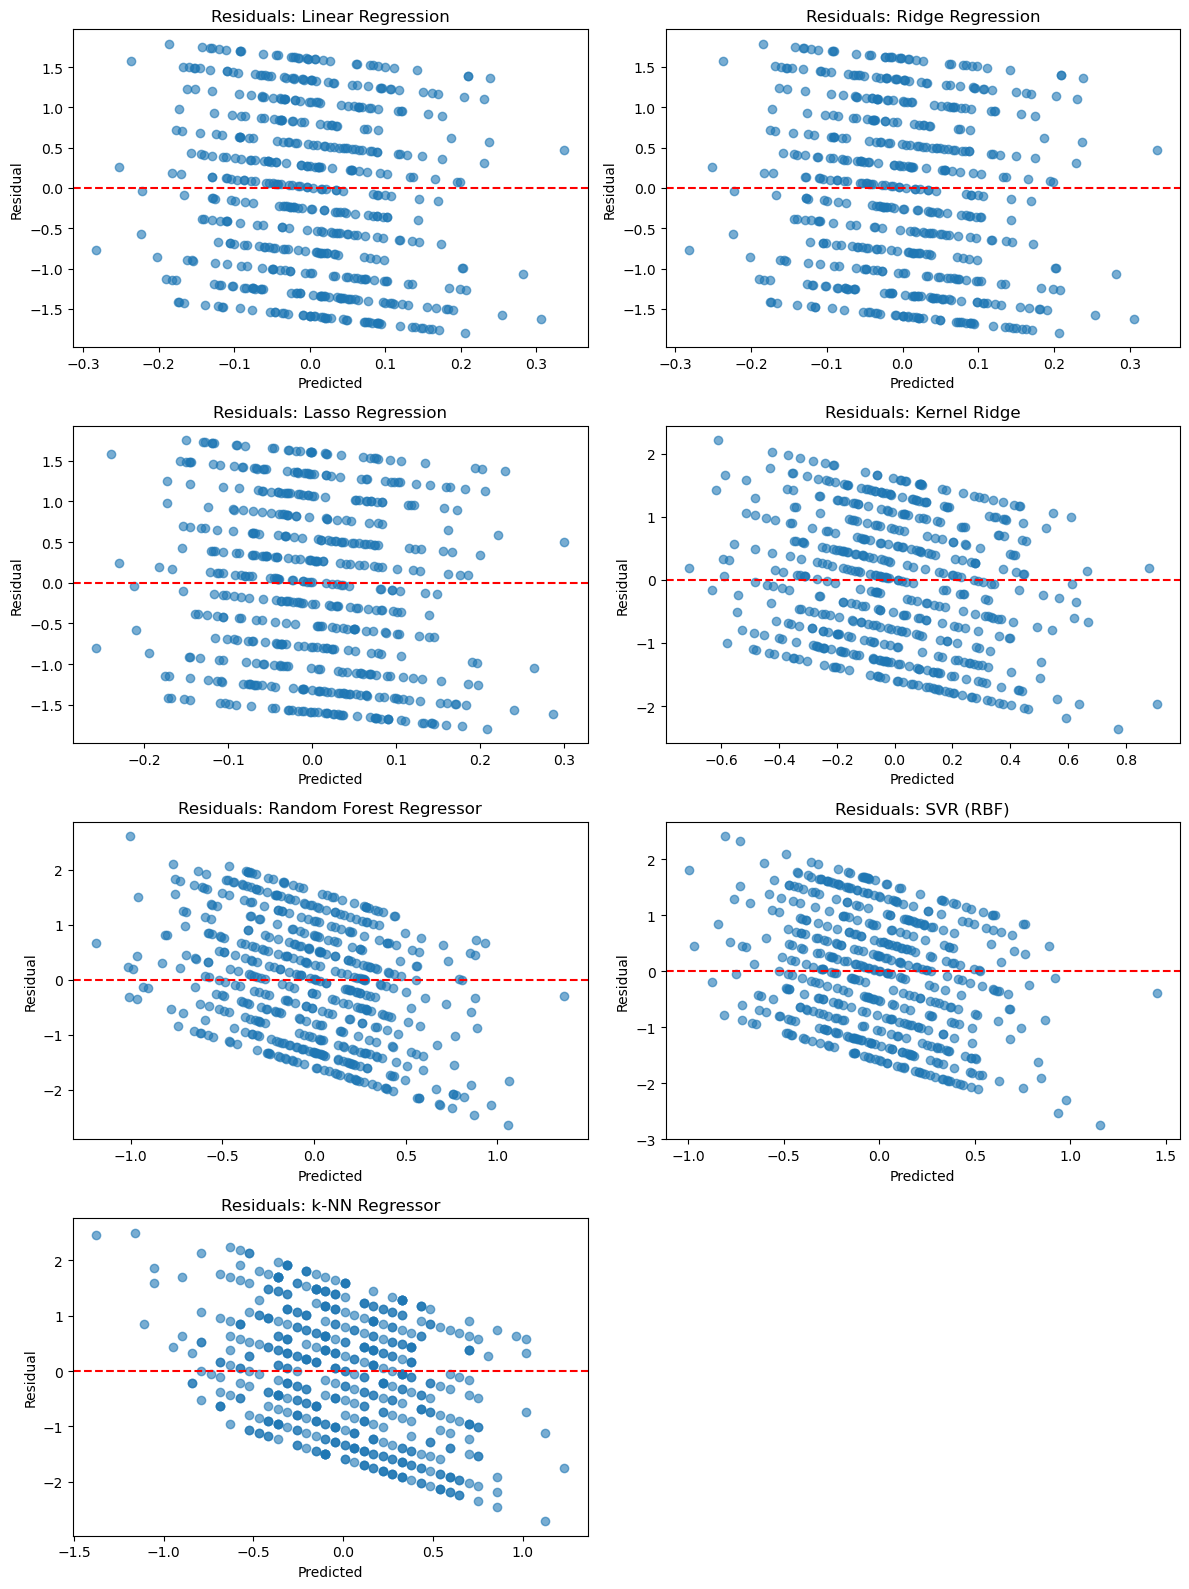

In [28]:
model_results = run_modeling_suite(features, target, target_feature)

target_type = model_results["target_type"]
print(f"Detected target type: {target_type}")
if "note" in model_results:
    print(model_results["note"])

if target_type == "continuous":
    regression_df = model_results.get("regression_results", pd.DataFrame())
    if not regression_df.empty:
        display(regression_df.reset_index(drop=True))
    else:
        print("No regression models produced results.")

    coefficients_df = model_results.get("coefficients", pd.DataFrame())
    if not coefficients_df.empty:
        display(coefficients_df.reset_index(drop=True))
    else:
        print("No coefficient-based models available for inspection.")

    residual_plots_data = model_results.get("residuals", {})
    if residual_plots_data:
        import matplotlib.pyplot as plt
        import numpy as np

        cols = 2
        rows = int(np.ceil(len(residual_plots_data) / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
        axes = np.atleast_1d(axes).flatten()
        for ax, (model_name, payload) in zip(axes, residual_plots_data.items()):
            ax.scatter(payload["pred"], payload["resid"], alpha=0.6)
            ax.axhline(0, color="red", linestyle="--")
            ax.set_title(f"Residuals: {model_name}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Residual")
        for ax in axes[len(residual_plots_data) :]:
            ax.set_visible(False)
        plt.tight_layout()
        plt.show()
    else:
        print("Residual plots were not generated.")
else:
    classification_df = model_results.get("classification_results", pd.DataFrame())
    if not classification_df.empty:
        display(classification_df.reset_index(drop=True))
    else:
        print("No classification models produced results.")

    confusion_matrices = model_results.get("confusion_matrices", {})
    if confusion_matrices:
        for model_name, cm_df in confusion_matrices.items():
            print(f"Confusion matrix — {model_name}")
            display(cm_df)
    else:
        print("No confusion matrices available.")